In [ ]:
import torch
import numpy as np

from torch._C import NoneType
from torch import nn
from torch.nn import functional as F

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-02-22 23:24:45--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2023-02-22 23:24:45 (30.4 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
print(len(text))
print(text[:100])

1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"vocabulary size = {vocab_size}")
print(''.join(chars))

vocabulary size = 65

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [ ]:
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] if c in stoi else -1 for c in s]
decode = lambda l: ''.join([itos[i] if i in itos else '' for i in l ])
tdecode = lambda l: ''.join([itos[int(i)] if int(i) in itos else '' for i in l ])

In [ ]:
print(encode("hii there>>>"))
print(decode([1,2,3,4,5, 10000, 10000000]))

[46, 47, 47, 1, 58, 46, 43, 56, 43, -1, -1, -1]
 !$&'


In [ ]:
print(decode(encode('hii there>>>')))

hii there


In [ ]:
data = torch.tensor(encode(text), dtype=torch.long)

In [ ]:
print(data.shape)
print(data.type())
print(len(text))
print(data[:10])

torch.Size([1115394])
torch.LongTensor
1115394
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47])


In [ ]:
print(decode([int(x) for x in data[0:10]]))
print(tdecode(data[0:10]))

First Citi
First Citi


In [ ]:
n = int(0.9*len(data))
train_data=data[:n]
val_data=data[n:]

all = torch.cat((train_data,val_data))
print(len(all)-len(data))

0


In [ ]:
block_size = 8
batch_size = 4
train_data[1:block_size+1]

tensor([47, 56, 57, 58,  1, 15, 47, 58])

In [ ]:
x=train_data[:block_size]
print(f"\n\nx = {x}")
y=train_data[1:block_size+1]
print(f"y   =   {y}\n\n")

for t in range(block_size):
  context = x[:t+1]
  target = y[t]
  print(f"context = {context}, target = {target}")



x = tensor([18, 47, 56, 57, 58,  1, 15, 47])
y   =   tensor([47, 56, 57, 58,  1, 15, 47, 58])


context = tensor([18]), target = 47
context = tensor([18, 47]), target = 56
context = tensor([18, 47, 56]), target = 57
context = tensor([18, 47, 56, 57]), target = 58
context = tensor([18, 47, 56, 57, 58]), target = 1
context = tensor([18, 47, 56, 57, 58,  1]), target = 15
context = tensor([18, 47, 56, 57, 58,  1, 15]), target = 47
context = tensor([18, 47, 56, 57, 58,  1, 15, 47]), target = 58


In [ ]:
def get_batch(split):
  data = train_data if split =='train' else val_data
  ix = torch.randint(len(data)-block_size, (batch_size,))
  x = torch.stack([data[t:t+block_size] for t in ix])
  y = torch.stack([data[t+1: t+block_size+1] for t in ix])
  return x,y

In [ ]:
torch.manual_seed(1337)
xb, yb = get_batch('train')
print(xb)
print(yb)
print(xb.shape, yb.shape)

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
torch.Size([4, 8]) torch.Size([4, 8])


In [ ]:
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
  def __init__(self, vocab_size):
    super().__init__()
    # how the 'Bigram' part is related to the embedding dimensionality?
    # both num_embeddings and embedding_dim equal to vocab_size (!!!) 
    # manual: https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
    self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

  def forward(self, idx, targets=None):
    # idx is the same as x: sequences of len block_size and targets are the
    # same as before (y), the correct expected outcomes
    # -- also looked up in the embedding table?

    logits = self.token_embedding_table(idx) #(B,T,C) batch, time, channel
    # channel is the vocabulary size (!!!); as if number of colurs = 65 :)
    #print(f"logits type: {type(logits)}, logits shape: {logits.shape}")

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)
      
    return logits, loss

  def generate(self, idx, max_new_tokens):
    for _ in range(max_new_tokens):
      logits, loss = self(idx);
      logits = logits[:,-1,:] # the last time slice, (BxC)

      # for each batch B get a distribution of classes C
      probs = F.softmax(logits, dim=-1) 

      # 1 sample from each row for each batch
      idx_next = torch.multinomial(probs, num_slamples=1) 

      idx = torch.cat((idx, idx_next), dim = 1)

    return idx



In [ ]:
m = BigramLanguageModel(vocab_size)

logits, loss = m(xb,yb)
print(logits.shape)
print(f"recall that batch size = {batch_size}")
ind = 17
offset = torch.argmax(logits[ind,:])
print(decode([ind]), decode([int(offset)]))
print(offset)
print(logits[0,:])
print(f"loss = {loss}, vs {float(-torch.log(torch.Tensor([1/65])))}")


torch.Size([32, 65])
recall that batch size = 4
E R
tensor(30)
tensor([-1.5101, -0.0948,  1.0927,  0.1505,  1.6347, -0.0518,  0.4996,  0.7216,
        -0.8968, -0.4122,  1.0030,  0.8508,  0.2178,  0.0328, -0.1699,  1.0659,
        -0.6177,  1.1824,  0.0214, -0.2154, -1.4623,  2.1707,  0.1624,  1.0296,
         0.4154,  0.6207,  0.2341, -0.0326,  1.0124,  1.5122, -0.3359,  0.2456,
         1.8682,  0.7536, -0.1177, -0.1967, -0.9552, -0.8995, -0.9583, -0.5945,
         0.1321, -0.5406,  0.1405, -0.7321,  1.1796,  1.3316, -0.2094,  0.0960,
         0.9040, -0.4032,  0.3027, -0.8034, -1.2537, -1.5195,  0.7446,  1.1914,
        -0.8061, -0.6290,  1.2447, -2.4400,  0.8408, -0.3993, -0.6126, -0.6597,
         0.7624], grad_fn=<SliceBackward0>)
loss = 4.878634929656982, vs 4.174387454986572


In [ ]:
print(logits.shape)
offsets = torch.argmax(logits, 0)
err = offsets - torch.tensor(range(vocab_size))
print(err)

torch.Size([32, 65])
tensor([ 14,   7,  12,   1,  25,   4,   3,  -2,   1,  18,  14,   3,  -4, -12,
         15,  12, -15, -13, -10,   6,   5, -21,   9, -23,   2,   4, -18, -21,
        -14, -13, -28,  -3, -32, -31,  -5,  -6, -11, -36, -37, -36, -14, -12,
        -32, -33, -39, -35, -45, -38, -20, -25, -26, -20, -23, -24, -26, -47,
        -52, -51, -56, -55, -59, -34, -31, -55, -59])


In [ ]:
# Peaking inside the nn.Embedding; the table is filled with random vectors
# -- they clearly aren't uniform

m1 = BigramLanguageModel(100)
arow = m1.token_embedding_table.weight[8,:].detach()
print(type(arow))
xxx = torch.tensor([[1,2,3],[4,5,6]])
xx = torch.tensor([1,2,3])

print(xxx.numpy())
print(xx.numpy())
print(type(xxx))
print(type(arow))
print(arow.numpy())

from scipy.stats import kstest

from numpy.random import uniform

print(f"row uniformity test = {kstest(arow, 'uniform')}")
print(f"row uniformity test = {kstest('uniform', arow)}")


print(f"\tscaled uniform dist: {kstest(arow, uniform(arow.min(),arow.max(),100))}")
print(f"\tscaled uniform dist: {kstest(uniform(arow.min(),arow.max(),100), uniform(arow.min(),arow.max(),100))}")

print(f"row mean = {arow.mean()}, row variance = {arow.var()}")
print(f"row max = {arow.max()}, row min = {arow.min()}")

<class 'torch.Tensor'>
[[1 2 3]
 [4 5 6]]
[1 2 3]
<class 'torch.Tensor'>
<class 'torch.Tensor'>
[ 0.91533643  0.28511047  0.02464807 -0.06170974  0.6286742  -1.624331
  0.6118156  -0.49852288  0.552538    0.64291096 -0.10637938 -0.0396924
  0.7712426   0.18075119 -1.3900133   0.913436    2.3732636   0.54066974
  0.2440587  -0.9574874   2.0510724   1.226435    0.06745743  0.30648127
  1.2500786  -1.7801679   0.557168    1.77622     0.1409601  -0.02861914
  0.2954816   0.5533202  -1.1178716   0.5589163  -0.5130493   0.5939884
  0.06512062  1.9891254  -0.43615332  0.14840713 -0.41575283  0.52409846
  0.7726778   0.89816624 -2.6723442  -1.6906072   0.63767874  0.65437585
  1.6451852  -1.031029    0.47609633 -0.04221632  0.7643164   0.17311026
  1.1340983  -1.7743453  -2.3412828  -0.8441665  -0.6238125   2.3082118
 -1.2818608   1.3256718   1.3595418   0.6562603   0.43274987  1.2447022
  0.90848625 -0.14481431 -0.43882647  0.9699627   0.71978116 -1.951609
  1.3540039  -1.895529    0.33774066

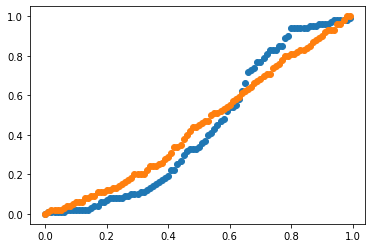

In [ ]:
import matplotlib.pyplot as plt

data = (arow-arow.min())/(arow.max()-arow.min())
#print(data)
N=len(data)
cdf = []
x=np.arange(0,1,0.01)
for t in x:
  cdf.append(len(data[data<t])/N)

N = 100
data_u = uniform(0,1,N)
#print(data_u)
cdf_u = []
x=np.arange(0,1,0.01)
for t in x:
  cdf_u.append(len(data_u[data_u<t])/N)

plt.scatter(x=x, y=cdf)
plt.scatter(x=x, y = cdf_u)
plt.show()

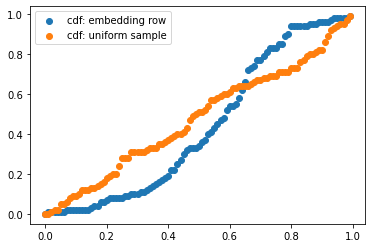

In [ ]:
# same with subplot for no good reason
fig = plt.figure()
ax = fig.add_subplot(111)
N=100
data = uniform(0,1,N)
cdf_u = []
x=np.arange(0,1,0.01)
for t in x:
  cdf_u.append(len(data[data<t])/N)

ax.scatter(x=x, y=cdf, label='cdf: embedding row')
ax.scatter(x=x, y=cdf_u, label='cdf: uniform sample')
plt.legend(loc='upper left')
plt.show()